# Slow transitions

In [1]:
%run 'backend.ipynb'
backend_test_function()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Backend import successful! - 2022-08-27 20:42:01.745851


# Economic parameters

In [2]:
gamma = 2. # CRRA utility parameter
def u(x): return x**(1-gamma) / (1-gamma) # Utility function
def du(x): return x**(-gamma) # Marginal utility
def du_inv(x): return x**(-1/gamma) # Inverse marginal utility
rho = 0.05 # Discount rate

r = 0.04 # Interest rate

In [3]:
def paretomean(zmin, zmax, zeta):
    return (zeta/(1-zeta)) * (zmax**(1-zeta)-zmin**(1-zeta)) / (zmin**(-zeta)-zmax**(-zeta))
    
def paretomean_target(zeta, zmin, zmax, zmean):
    return paretomean(zmin, zmax, zeta)-zmean

def solve_for_zeta_from_paretomean(zmin, zmax, zmean):
    return scipy.optimize.fsolve(paretomean_target, 1.5, args=(zmin, zmax, zmean)).squeeze()

In [4]:
# Power Law Income
zmin, zmax = 50000., 1e6
zmean = 100000. # Congressional Research Service, "The U.S. Income Distribution: Trends and Issues" (2021)

zeta = solve_for_zeta_from_paretomean(zmin, zmax, zmean)
print('zeta:', zeta)

logincomegrowthp9010 = 0.8 # Bloom et al., "The Great Micro Moderation" (2017)
s2 = (logincomegrowthp9010 / (2 * scipy.stats.norm.ppf(0.9)))**2
print('s2:', s2)

g = s2 * (1-zeta) / 2
print('g:', g)

zeta: 1.8676166940743482
s2: 0.09741992966043918
g: -0.04226157865447289


In [5]:
# Assets
amin, amax = -zmin, 50*zmax

# Hamilton-Jacobi-Bellman Equation

## Spectral Method Setup

In [6]:
N = 70
a_sp, [Da, Daa] = dm.chebdif(N, 2)
a_sp, [Da, Daa] = rescale_nodes_and_derivatives(a_sp, [Da, Daa], left=amin, right=amax)

M = 80
z_sp, [Dz, Dzz] = dm.chebdif(M, 2)
z_sp, [Dz, Dzz] = rescale_nodes_and_derivatives(z_sp, [Dz, Dzz], left=zmin, right=zmax)

print(N, M, N*M)

70 80 5600


In [7]:
aidx_sp = pd.Index(a_sp, name='a')
zidx_sp = pd.Index(z_sp, name='z')
midx_sp = pd.MultiIndex.from_product([aidx_sp, zidx_sp])

amin_, amax_ = a_sp[0], a_sp[-1]
zmin_, zmax_ = z_sp[0], z_sp[-1]

aa_sp = midx_sp.get_level_values('a').values
zz_sp = midx_sp.get_level_values('z').values

mumu_sp = g*zz_sp
sig2sig2_sp = s2*zz_sp**2

D_a = kronecker_broadcast_along_index_level(Da, midx_sp, 'a')
D_z = kronecker_broadcast_along_index_level(Dz, midx_sp, 'z')
D_zz = kronecker_broadcast_along_index_level(Dzz, midx_sp, 'z')

aminidx = int_index_from_labels(midx_sp, amin_)
amaxidx = int_index_from_labels(midx_sp, amax_)

v0_sp = u(zz_sp + r*aa_sp)/rho

In [8]:
maxiter = 1000
crit = 1e-8

## Spectral Method Solution

In [10]:
v_sp = v0_sp.copy()

for i in trange(maxiter):
    
    delta = 0.01*np.exp(i)
    
    dv = D_a@v_sp
    c = du_inv(dv)
    s = zz_sp + r*aa_sp - c
    
    A = s.reshape(-1,1)*D_a + mumu_sp.reshape(-1,1)*D_z + (sig2sig2_sp/2).reshape(-1,1)*D_zz
    B = np.eye(N*M)*(1/delta + rho) - A
    b = u(c) + v_sp/delta
    
    bc1idx = int_index_from_labels(midx_sp, (slice(None),[zmin_,zmax_]))
    B[bc1idx] = D_z[bc1idx]
    b[bc1idx] = 0
    
    v_sp_next = np.linalg.solve(B, b)
    s_next = zz_sp + r*aa_sp - du_inv(D_a@v_sp_next)

    bc2idx_amin = aminidx[s_next[aminidx]<0]
    bc2idx_amax = amaxidx[s_next[amaxidx]>0]
    bc2idx = np.union1d(bc2idx_amin, bc2idx_amax)

    B[bc2idx] = D_a[bc2idx]
    b[bc2idx] = du(zz_sp + r*aa_sp)[bc2idx]
    
    v_old, s_sp = v_sp.copy(), s.copy()
    v_sp = np.linalg.solve(B, b)
    
    dist = np.max(np.abs(v_sp - v_old))
    if dist < crit:
        print('Finished! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
        break
    elif i == maxiter - 1 : print('Failed to converge! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)

  0%|          | 0/1000 [00:00<?, ?it/s]

Finished! - Loops: 13  - Last distance: 6.0517537600227956e-09  - Last delta: 1627.5479141900391


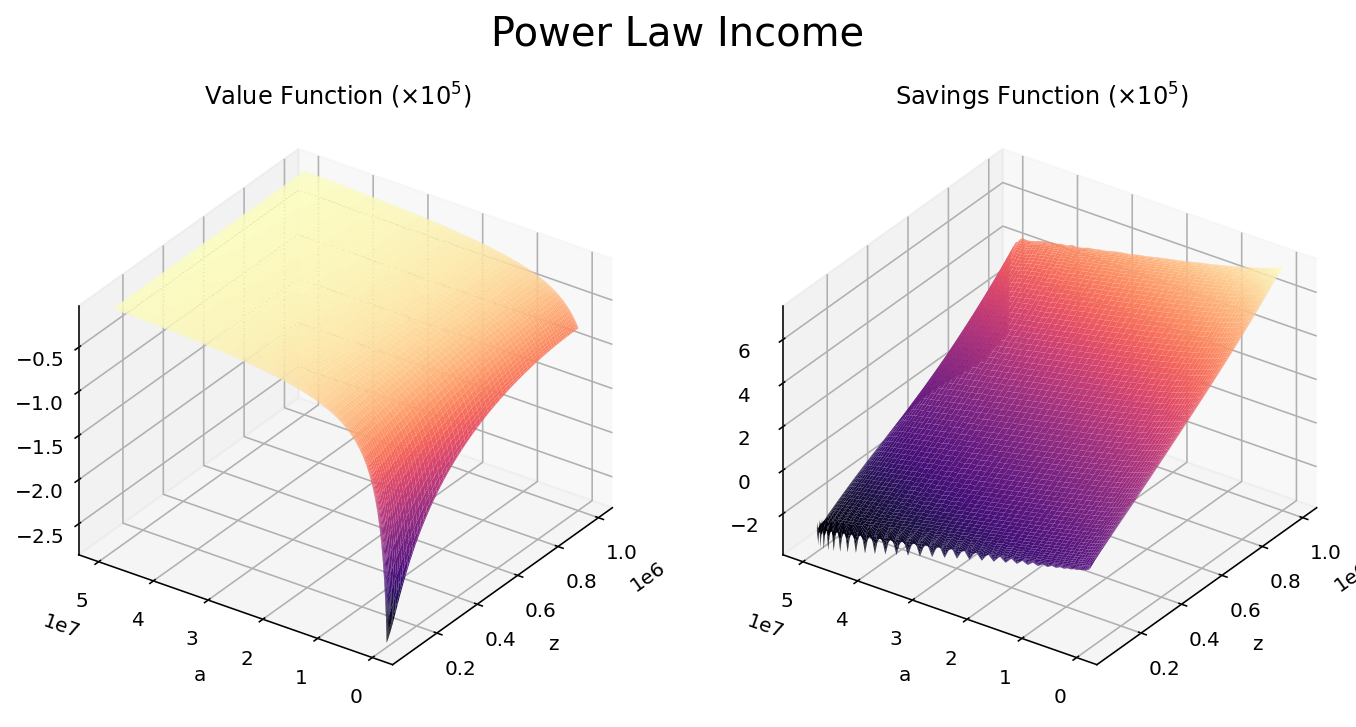

Saved to: eigenvalues_value_function_savings.pdf


In [27]:
plot_3D_surfaces_side_by_side(zz_sp, aa_sp, v_sp, zz_sp, aa_sp, s_sp, 'Value Function', 'Savings Function', 'Power Law Income', 'eigenvalues_value_function_savings', sharez=False)

# Kolmogorov Forward Equation

## Finite Volume Setup

In [12]:
I = 300
a_fv = np.linspace(amin,amax,I)
da_fv = a_fv[1]-a_fv[0]

J = 300
z_fv = np.linspace(zmin,zmax,J)
dz_fv = z_fv[1]-z_fv[0]

print(I, J, I*J)

300 300 90000


In [13]:
aidx_fv = pd.Index(a_fv, name='a')
zidx_fv = pd.Index(z_fv, name='z')
midx_fv = pd.MultiIndex.from_product([aidx_fv, zidx_fv])

aa_fv = midx_fv.get_level_values('a').values
zz_fv = midx_fv.get_level_values('z').values

mumu_fv = g*zz_fv
sig2sig2_fv = s2*zz_fv**2

s_sp_interp = sp.interpolate.RectBivariateSpline(a_sp, z_sp, s_sp.reshape(N,M))(a_fv, z_fv).flatten()

In [14]:
Da_fw = (1/da_fv)*(sparse.diags(np.ones(I-1), offsets=1)-sparse.diags(np.ones(I), offsets=0))
Da_fw[:,0] = -Da_fw[:,1]

Da_bw = (1/da_fv)*(sparse.diags(np.ones(I), offsets=0)-sparse.diags(np.ones(I-1), offsets=-1))
Da_bw[:,-1] = -Da_bw[:,-2]


Dz_fw = (1/dz_fv)*(sparse.diags(np.ones(J-1), offsets=1)-sparse.diags(np.ones(J), offsets=0))
Dz_fw[:,0] = -Dz_fw[:,1]

Dz_bw = (1/dz_fv)*(sparse.diags(np.ones(J), offsets=0)-sparse.diags(np.ones(J-1), offsets=-1))
Dz_bw[:,-1] = -Dz_bw[:,-2]

Dzz_cent = (1/dz_fv**2)*(sparse.diags(np.ones(J-1), offsets=1)-2*sparse.diags(np.ones(J), offsets=0)+sparse.diags(np.ones(J-1), offsets=-1))
Dzz_cent[1,0], Dzz_cent[-2,-1] = -Dzz_cent[0,0], -Dzz_cent[-1,-1]

/Users/constantinschesch/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [15]:
D_a_fw = kronecker_broadcast_along_index_level(Da_fw, midx_fv, 'a')
D_a_bw = kronecker_broadcast_along_index_level(Da_bw, midx_fv, 'a')

D_z_fw = kronecker_broadcast_along_index_level(Dz_fw, midx_fv, 'z')
D_z_bw = kronecker_broadcast_along_index_level(Dz_bw, midx_fv, 'z')
D_zz_cent = kronecker_broadcast_along_index_level(Dzz_cent, midx_fv, 'z')

## Finite Volume Solution - Icome Only

In [16]:
mu_fv = g*z_fv
sig2_fv = s2*z_fv**2

C_income_only_income_drift = - Dz_fw*sparse.diags(mu_fv)
C_income_only_income_diffusion = Dzz_cent*sparse.diags(sig2_fv/2)

C_income_only = C_income_only_income_drift + C_income_only_income_diffusion

test_transpose_generator(C_income_only)

l, g_income_only = sparse.linalg.eigs(C_income_only, sigma=0, k=1)
l, g_income_only = np.real(l).squeeze(), np.real(g_income_only).flatten()
print('l:', l)

g_income_only = g_income_only / (g_income_only.sum()*dz_fv)

Diagonal -> Min: -9663.649344032954  Mean: -3397.5017102295496  Max: -24.790933960966758
Off-diagonal -> Min: 0.0  Mean: 11.325005700765166  Max: 9663.649344032954
Maximum absolute off-diagonal vs diagonal error: 9.094947017729282e-13
l: -1.870067884700784e-16


## Finite Volume Solution - Income and Wealth

In [17]:
C_savings_drift = - (D_a_bw*sparse.diags(np.maximum(s_sp_interp,0))+D_a_fw*sparse.diags(np.minimum(s_sp_interp,0)))
C_income_drift = - (D_z_bw*sparse.diags(np.maximum(mumu_fv,0))+D_z_fw*sparse.diags(np.minimum(mumu_fv,0)))
C_income_diffusion = D_zz_cent*sparse.diags(sig2sig2_fv/2)

C_income_wealth = C_savings_drift + C_income_drift + C_income_diffusion

test_transpose_generator(C_income_wealth)

Diagonal -> Min: -9668.018024968238  Mean: -3398.8485536974363  Max: -24.79093493489857
Off-diagonal -> Min: 0.0  Mean: 0.03776498392997151  Max: 9663.649344032954
Maximum absolute off-diagonal vs diagonal error: 1.6058265828178264e-12


In [18]:
l, g_income_wealth = sparse.linalg.eigs(C_income_wealth, sigma=0, k=1)
l, g_income_wealth = np.real(l).squeeze(), np.real(g_income_wealth).flatten()
g_income_wealth = g_income_wealth / (g_income_wealth.sum()*da_fv*dz_fv)

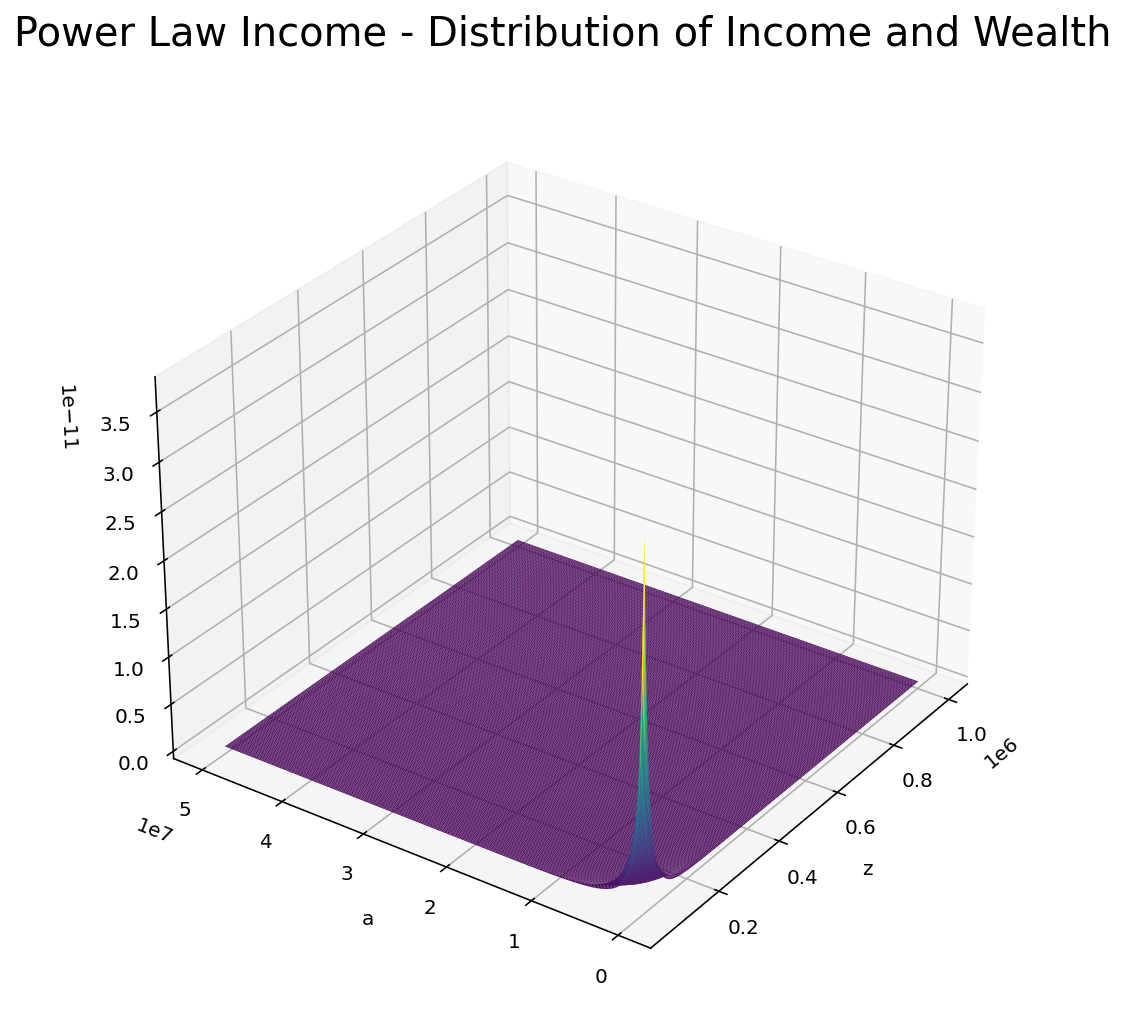

Saved to: eigenvalues_density_plot.pdf


In [19]:
fig = plt.figure(figsize=(7,7))
ax0 = fig.add_subplot(111, projection='3d')
ax0.plot_surface(zz_fv.reshape(I,J), aa_fv.reshape(I,J), g_income_wealth.reshape(I,J), cmap='viridis', linewidth=0, rstride=1, cstride=1, antialiased=True)
ax0.view_init(30, 35+180)

ax0.set_xlabel('z')
ax0.set_ylabel('a')

plt.suptitle('Power Law Income - Distribution of Income and Wealth', size=20, y=1)
plt.tight_layout()

savefig(fig, 'eigenvalues_density_plot')

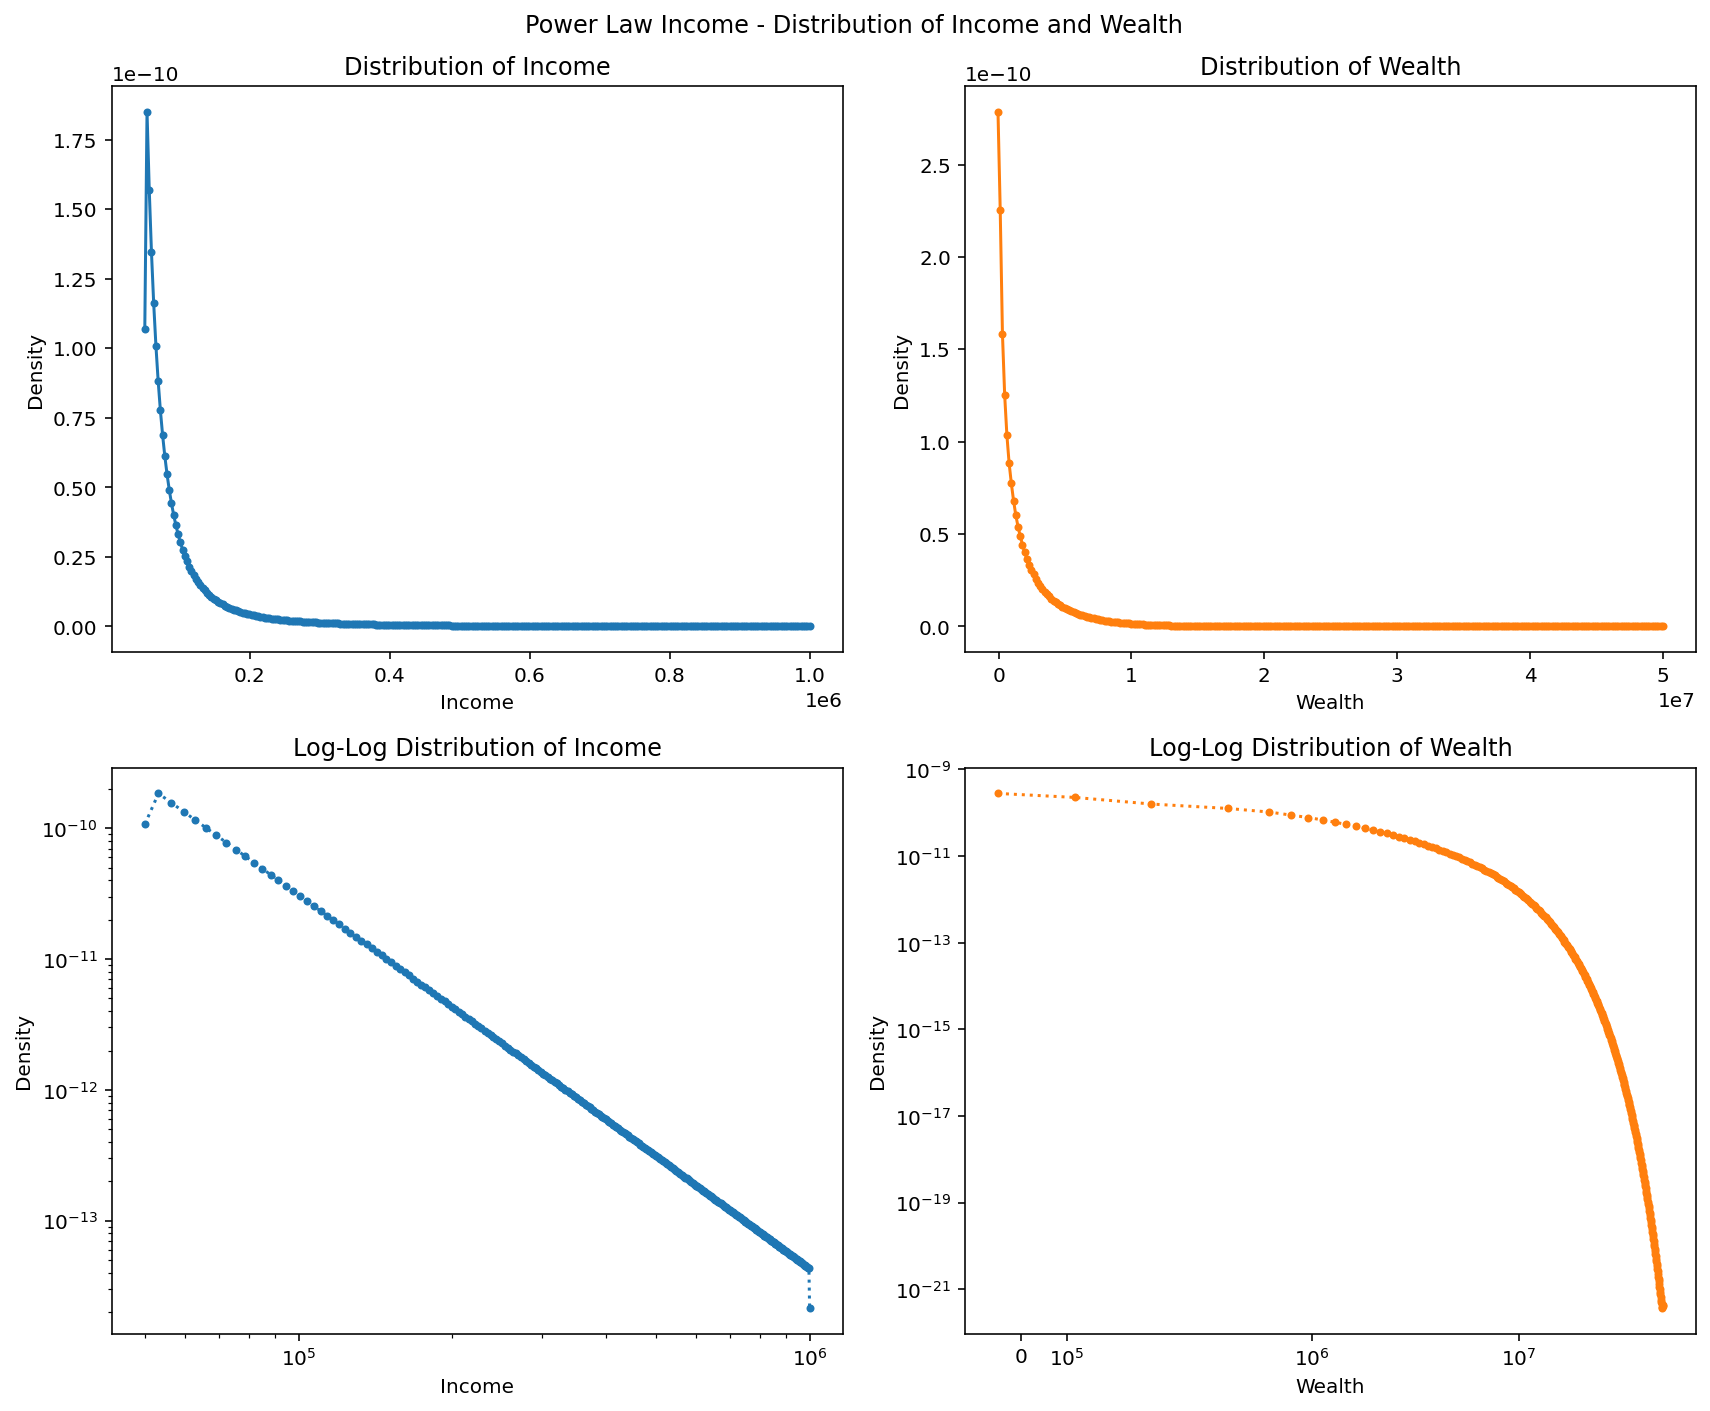

Saved to: eigenvalues_density_cross_section.pdf


In [36]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
ax = ax.flatten()

ax[0].plot(z_fv, g_income_wealth.reshape(I,J).sum(axis=0), 'C0.-')
ax[0].set_title('Distribution of Income')
ax[0].set_xlabel('Income')
ax[0].set_ylabel('Density')

ax[1].plot(a_fv, g_income_wealth.reshape(I,J).sum(axis=1), 'C1.-')
ax[1].set_title('Distribution of Wealth')
ax[1].set_xlabel('Wealth')
ax[1].set_ylabel('Density')

ax[2].plot(z_fv, g_income_wealth.reshape(I,J).sum(axis=0), 'C0.:')
ax[2].set_title('Log-Log Distribution of Income')
ax[2].set_xlabel('Income')
ax[2].set_ylabel('Density')
ax[2].set_xscale('log')
ax[2].set_yscale('log')

ax[3].plot(a_fv, g_income_wealth.reshape(I,J).sum(axis=1), 'C1.:')
ax[3].set_title('Log-Log Distribution of Wealth')
ax[3].set_xlabel('Wealth')
ax[3].set_ylabel('Density')
ax[3].set_xscale('symlog', linthresh=5e5)
ax[3].set_yscale('log')

plt.suptitle('Power Law Income - Distribution of Income and Wealth')
plt.tight_layout()
savefig(fig, 'eigenvalues_density_cross_section')

# Eigenvalues and Transition Speeds

In [21]:
L_income_only, _ = sparse.linalg.eigs(C_income_only.T, sigma=0, k=20)
L_income_wealth, _ = sparse.linalg.eigs(C_income_wealth.T, sigma=0, k=20)

In [48]:
%timeit (C_income_wealth.T+C_income_wealth)/2
%timeit sparse.linalg.eigs(E_income_wealth, sigma=0, k=1)

6.54 ms ± 392 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
930 ms ± 81.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
I, J, I*J

(300, 300, 90000)

In [49]:
C_income_wealth.shape

(90000, 90000)

In [22]:
E_income_only = (C_income_only.T+C_income_only)/2
E_income_wealth = (C_income_wealth.T+C_income_wealth)/2

l_income_only, _ = sparse.linalg.eigs(E_income_only, sigma=0, k=5)
l_income_wealth, _ = sparse.linalg.eigs(E_income_wealth, sigma=0, k=5)

l_income_only = np.real_if_close(l_income_only)
l_income_wealth = np.real_if_close(l_income_wealth)

In [23]:
Ls = [L_income_only, L_income_wealth]
ls = [l_income_only, l_income_wealth]

titles = ['Power Law Income Only', 'Power Law Income and Credit-Constrained Wealth']
colors = ['C0', 'C1']

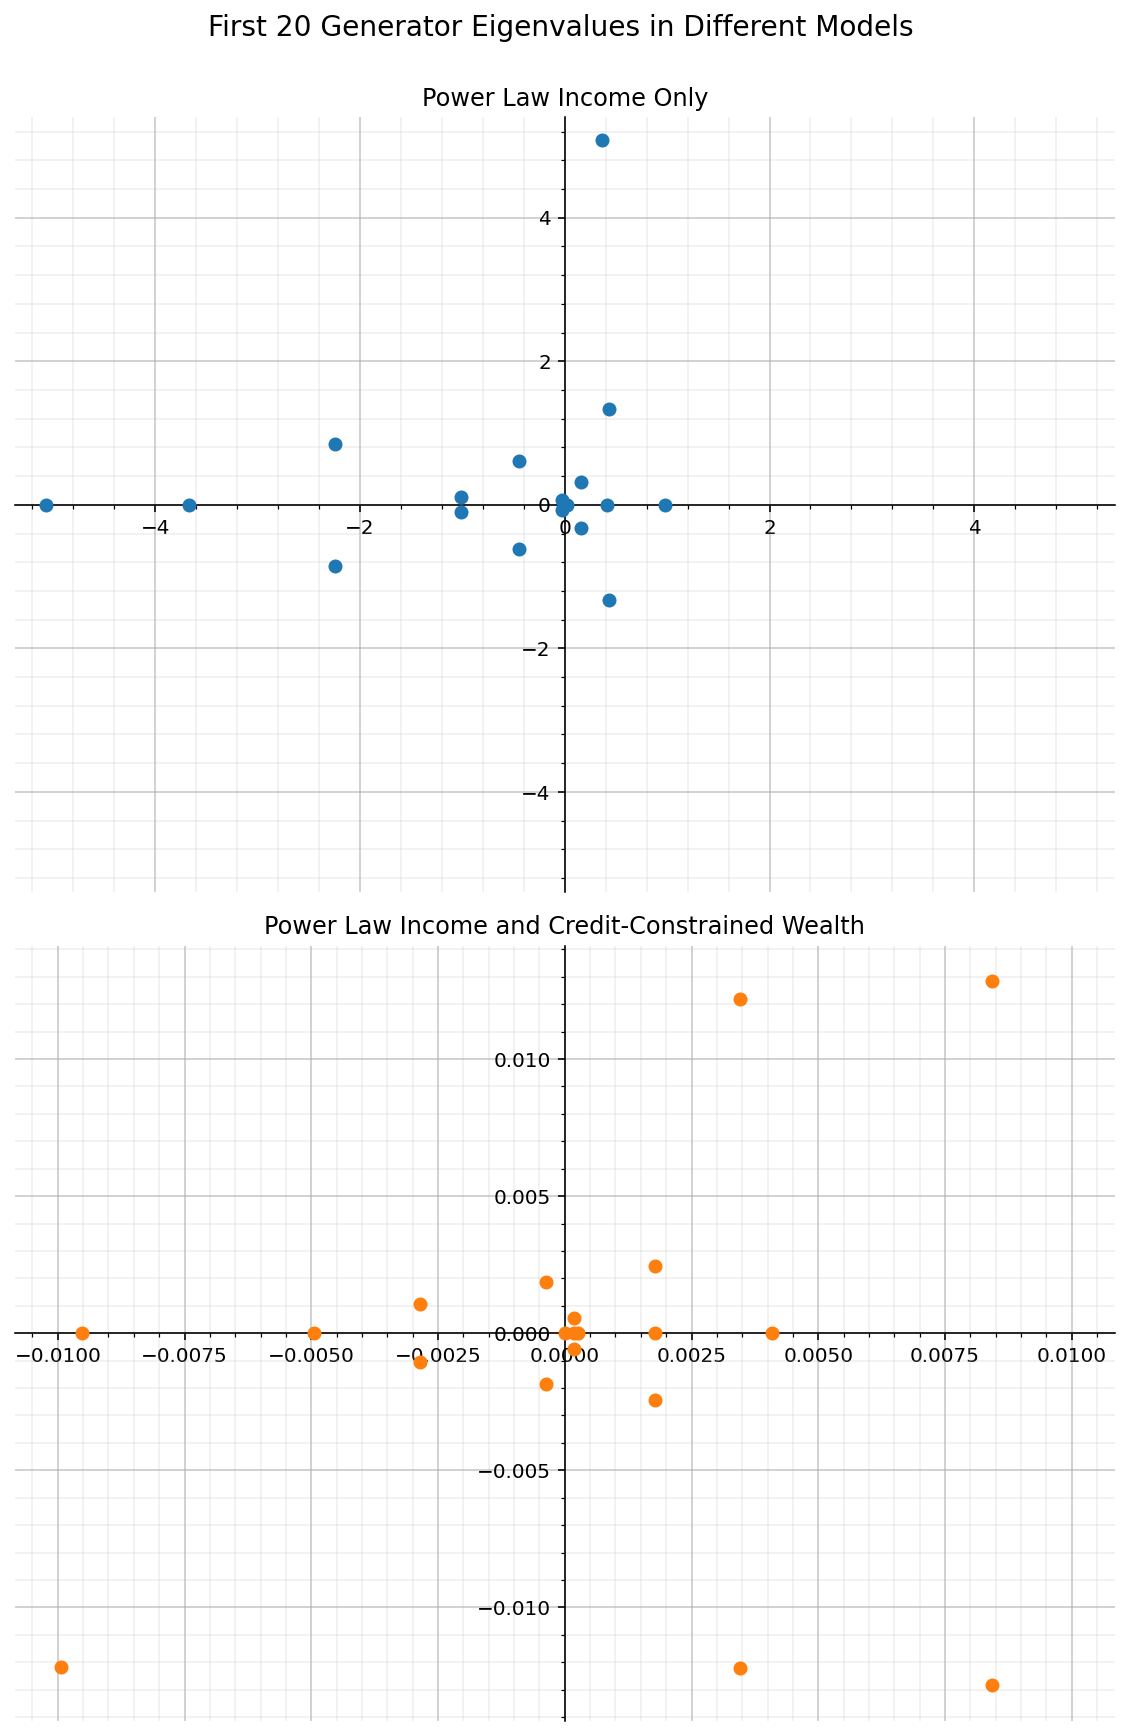

Saved to: eigenvalues_generator_eigenvalues.pdf


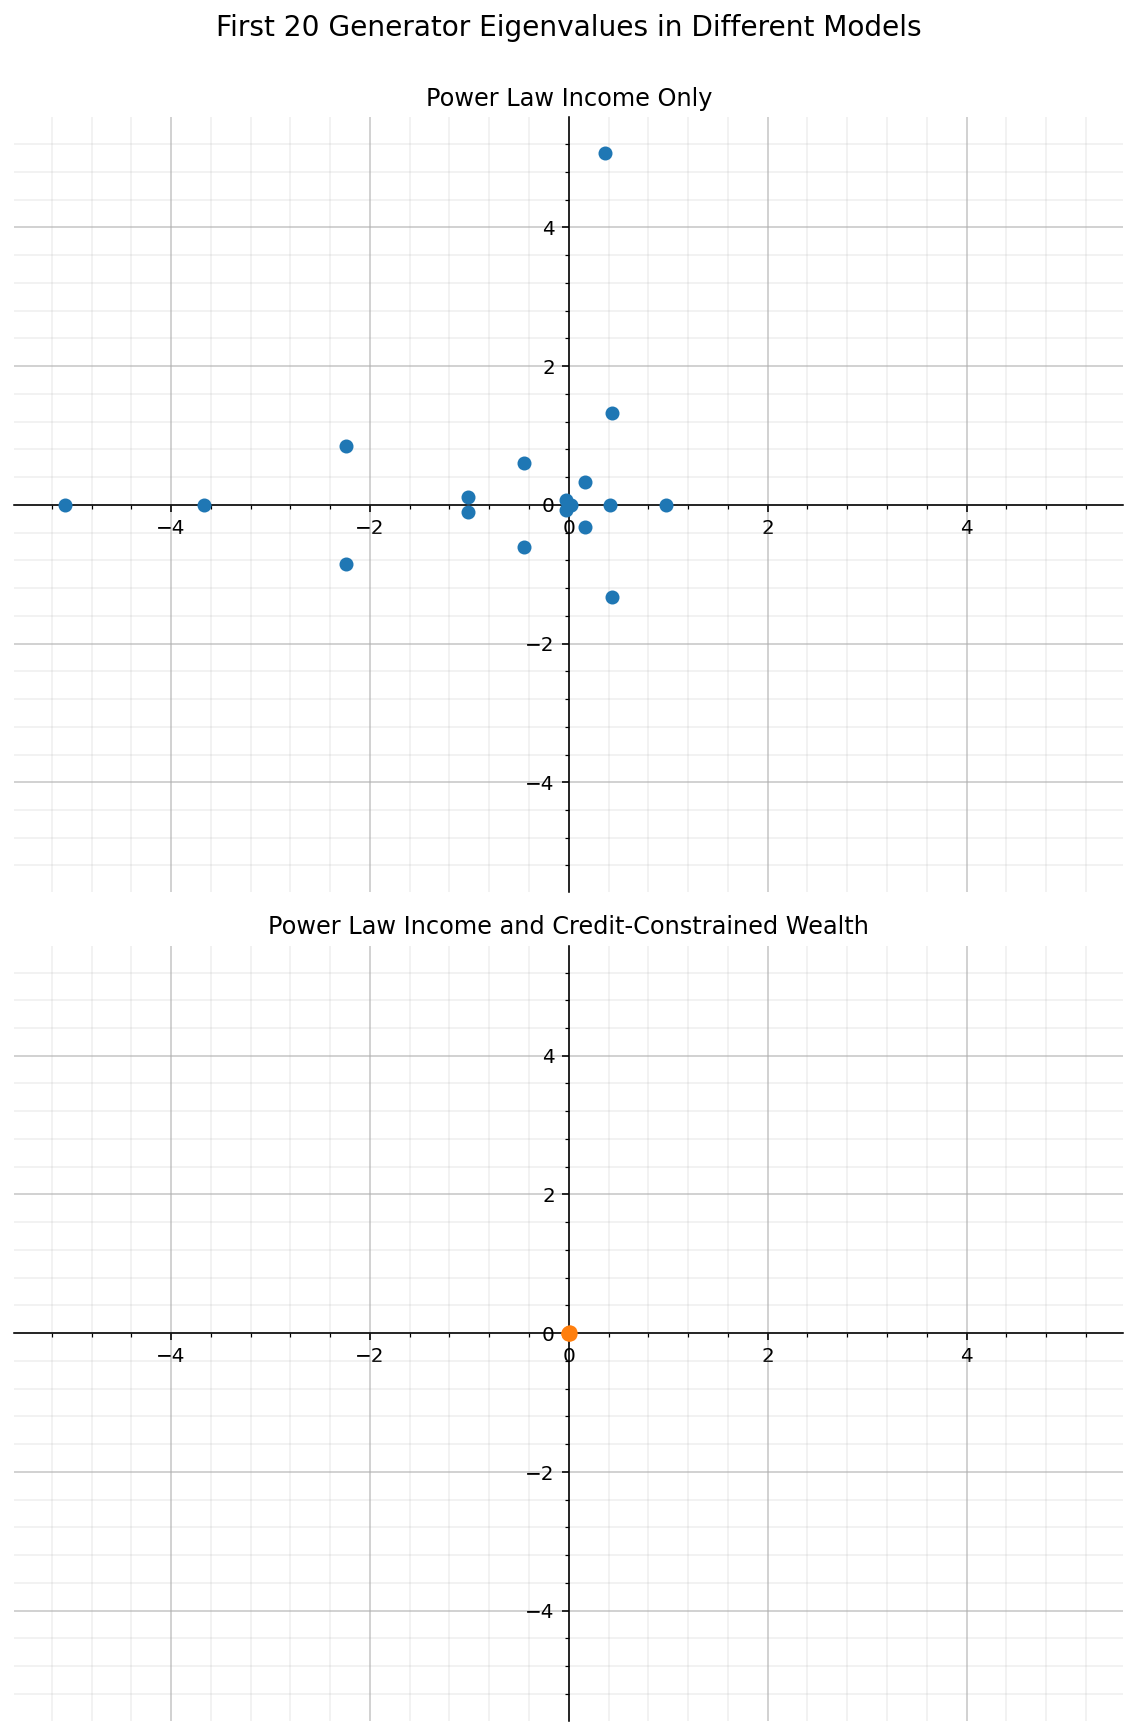

Saved to: eigenvalues_generator_eigenvalues_shareaxes.pdf


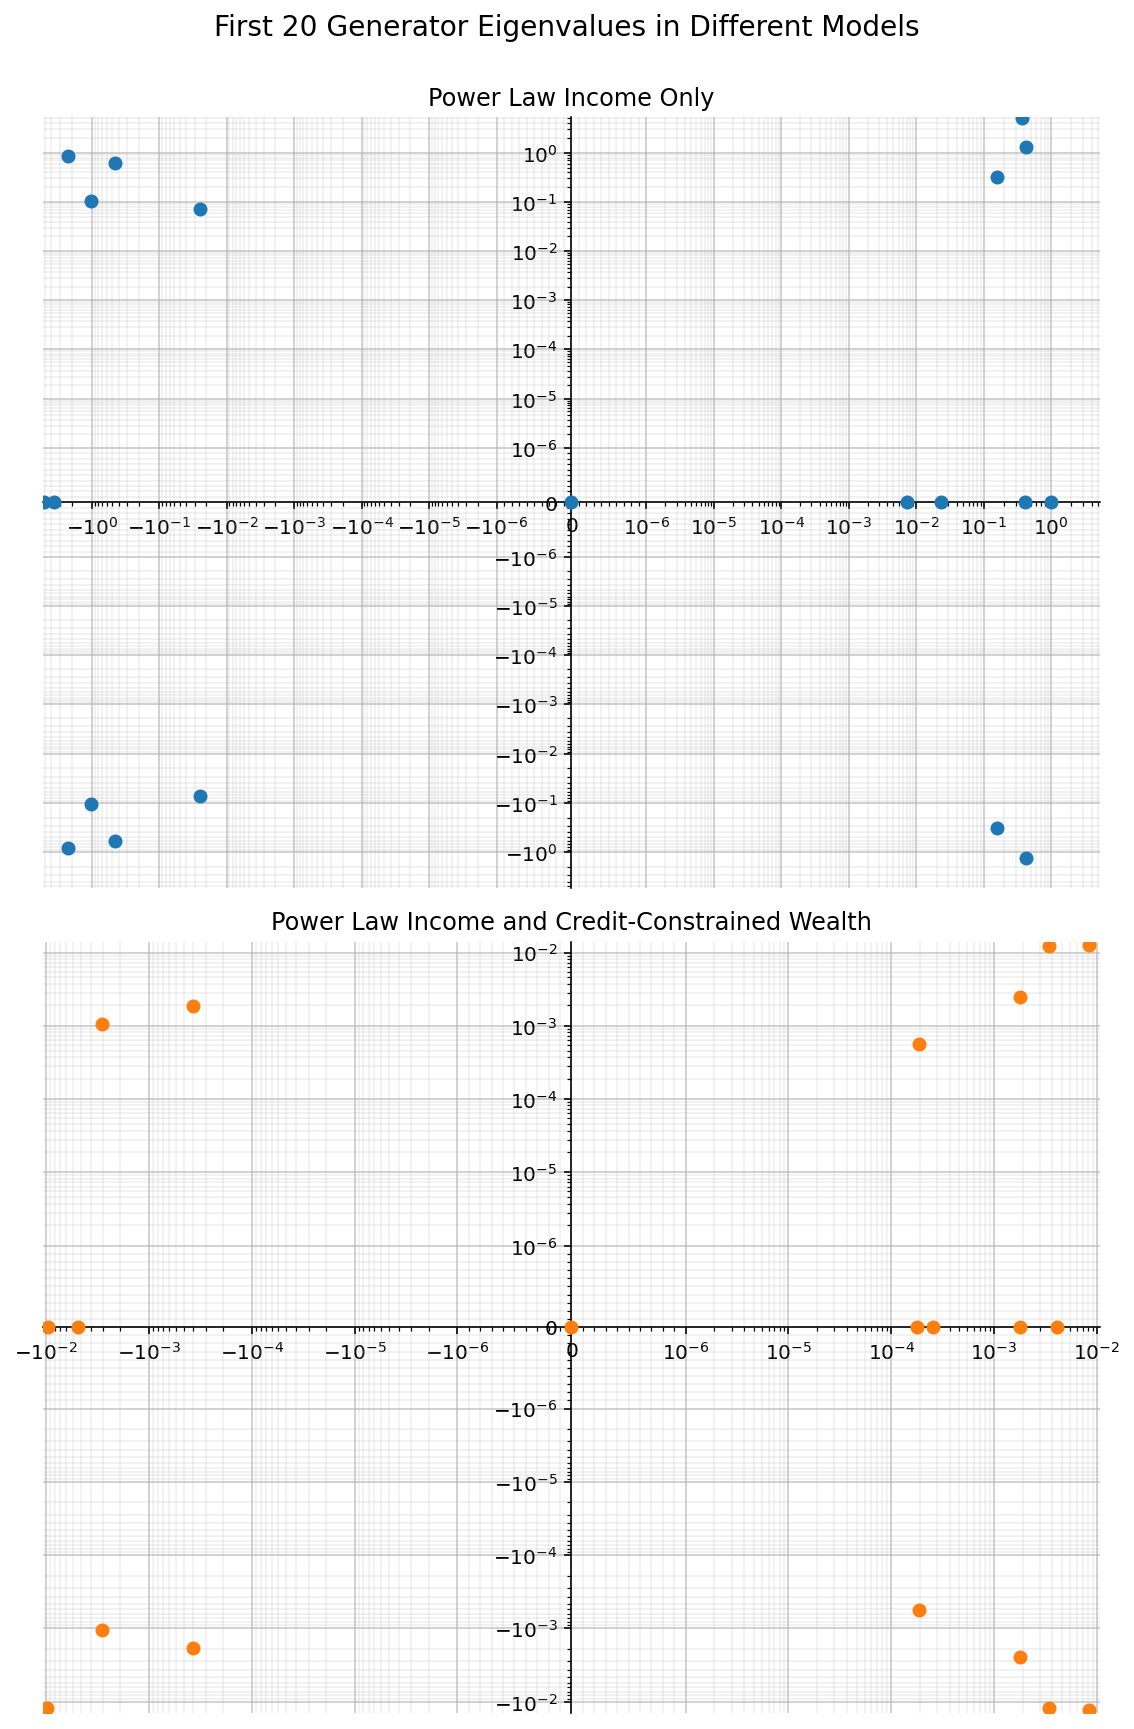

Saved to: eigenvalues_generator_eigenvalues_logaxes.pdf


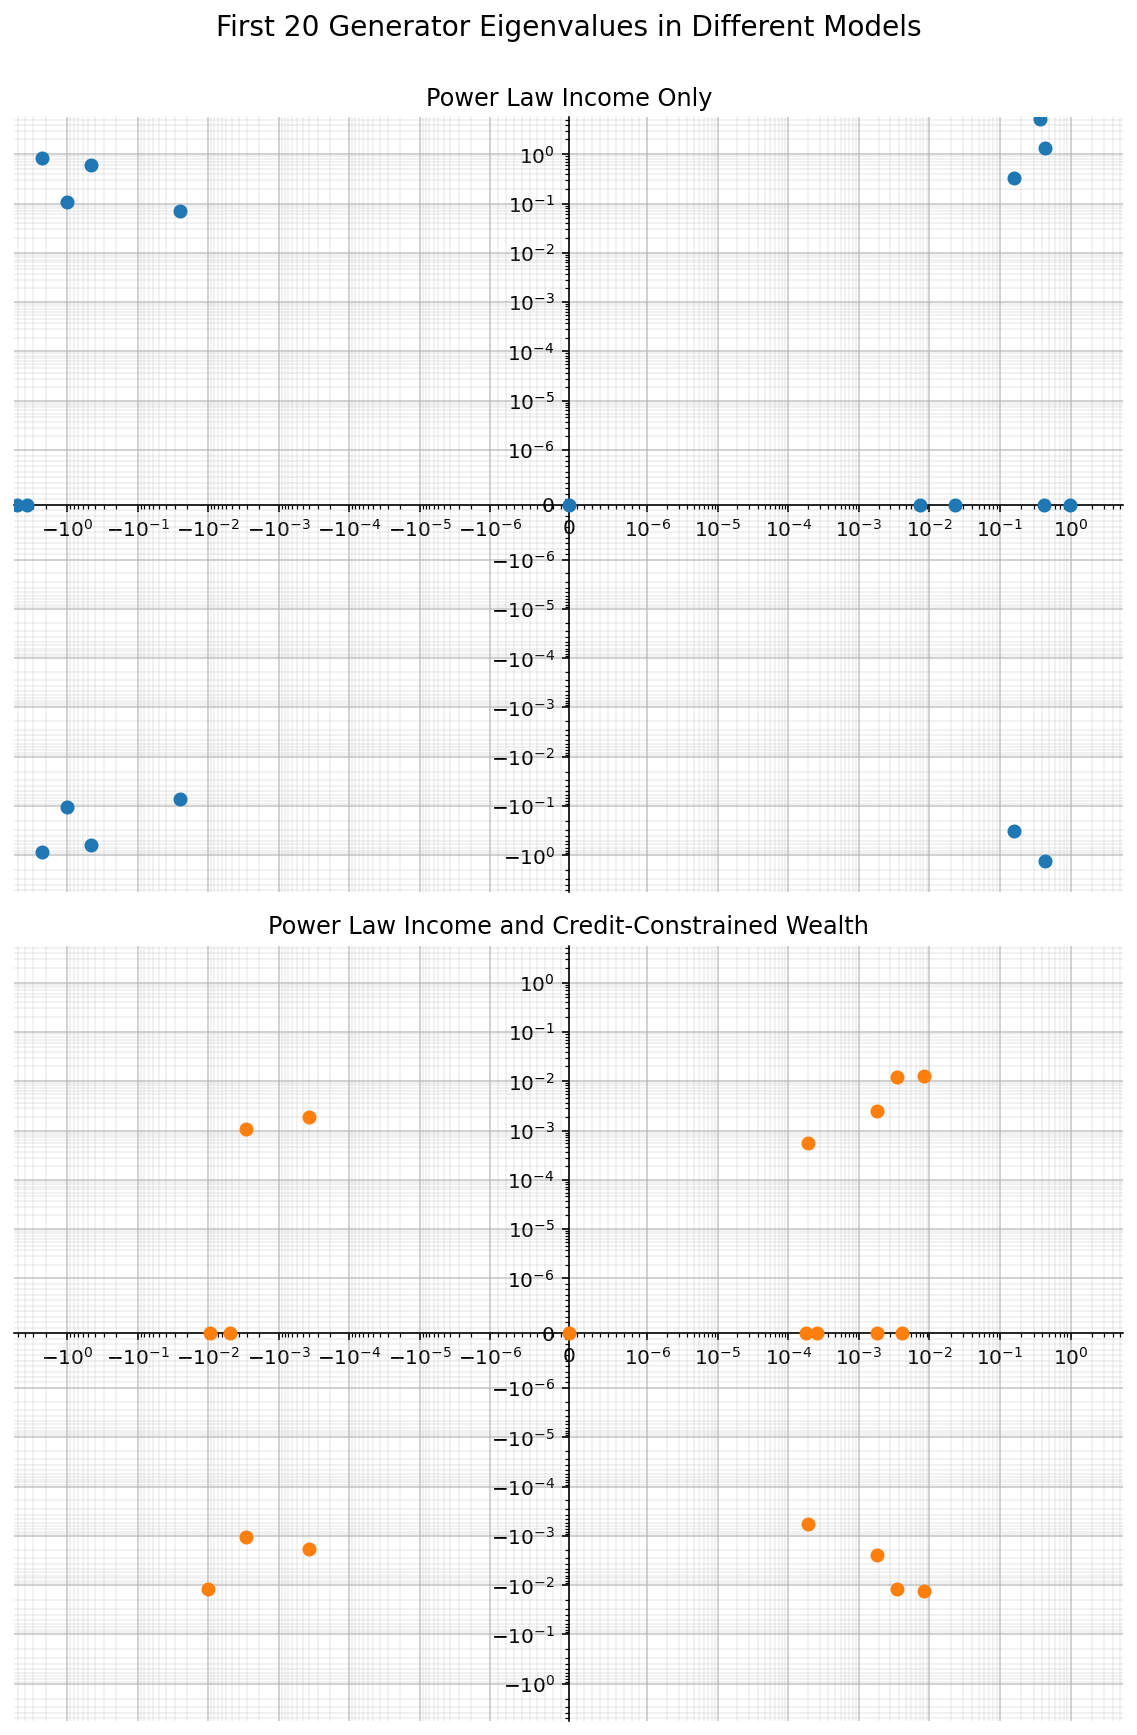

Saved to: eigenvalues_generator_eigenvalues_shareaxes_logaxes.pdf


In [24]:
for logaxes in [False, True]:
    for shareaxes in [False, True]:
        
        absxmax, absymax = 0, 0

        fig, ax = plt.subplots(2, 1, figsize=(8,12))
        ax = ax.flatten()

        for i, L in enumerate(Ls):

            ax[i].scatter(np.real(L), np.imag(L), c=colors[i], zorder=3)

            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['bottom'].set_position('zero')
            ax[i].spines['left'].set_position('zero')

            ax[i].xaxis.set_major_locator(ticker.AutoLocator())
            ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax[i].yaxis.set_major_locator(ticker.AutoLocator())
            ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(5))                
            
            ax[i].grid(which='minor', alpha=0.2)
            ax[i].grid(which='major', alpha=0.7)
            ax[i].set_axisbelow(True)

            if shareaxes:
                absxmax = np.maximum(absxmax, 1.1*np.abs(np.real(L)).max())
                ax[i].set_xlim([-absxmax, absxmax])
                absymax = np.maximum(absymax, 1.1*np.abs(np.imag(L)).max())
                ax[i].set_ylim([-absymax, absymax])
            else:
                ax[i].set_xlim([-np.abs(ax[i].get_xlim()).max(), np.abs(ax[i].get_xlim()).max()])
                ax[i].set_ylim([-np.abs(ax[i].get_ylim()).max(), np.abs(ax[i].get_ylim()).max()])
                
            if logaxes:
                ax[i].set_xscale('symlog', linthresh=1e-6)
                ax[i].set_yscale('symlog', linthresh=1e-6)
                ax[i].xaxis.set_minor_locator(MinorSymLogLocator(linthresh=0.01))
                ax[i].yaxis.set_minor_locator(MinorSymLogLocator(linthresh=0.01))

            ax[i].set_title(titles[i])

        plt.suptitle('First 20 Generator Eigenvalues in Different Models', size=14, y=1)
        plt.tight_layout()
        filename = 'eigenvalues_generator_eigenvalues'
        if shareaxes: filename += '_shareaxes'
        if logaxes: filename += '_logaxes'
        savefig(fig, filename)

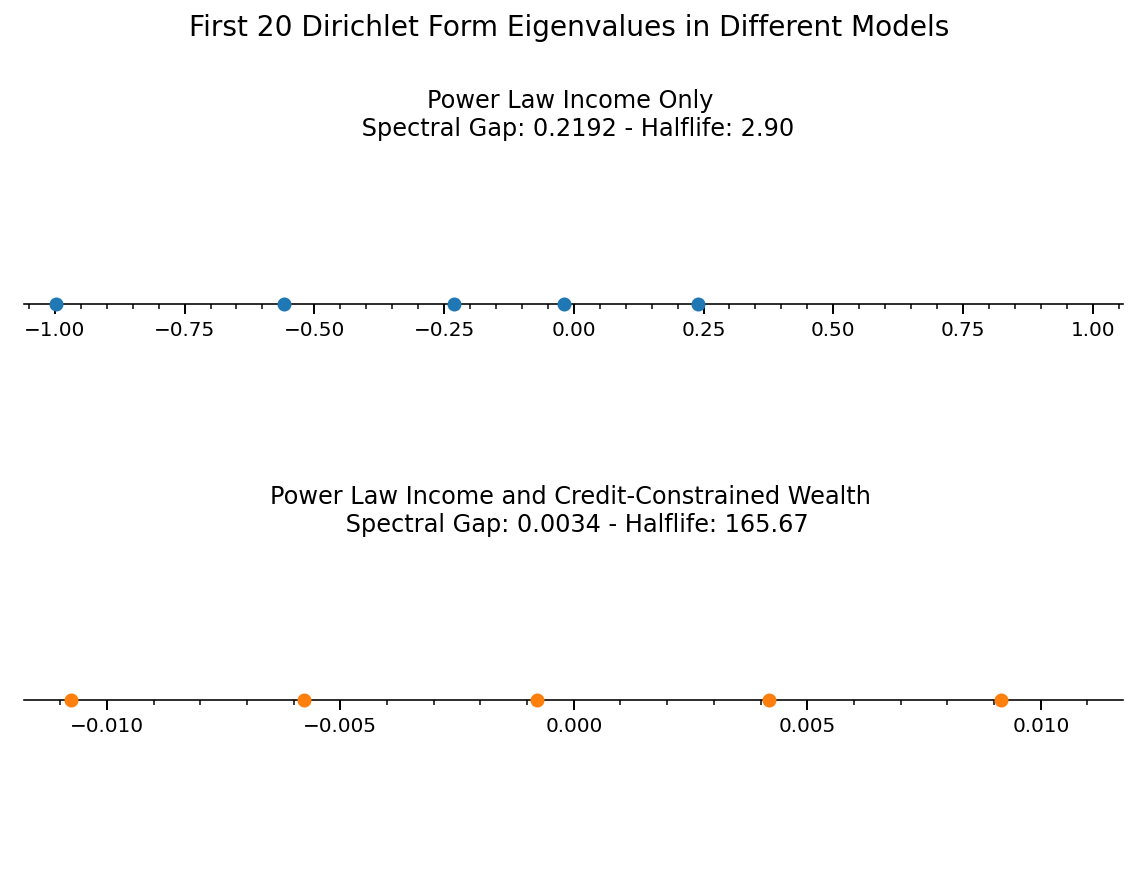

Saved to: eigenvalues_dirichlet_form_eigenvalues.pdf


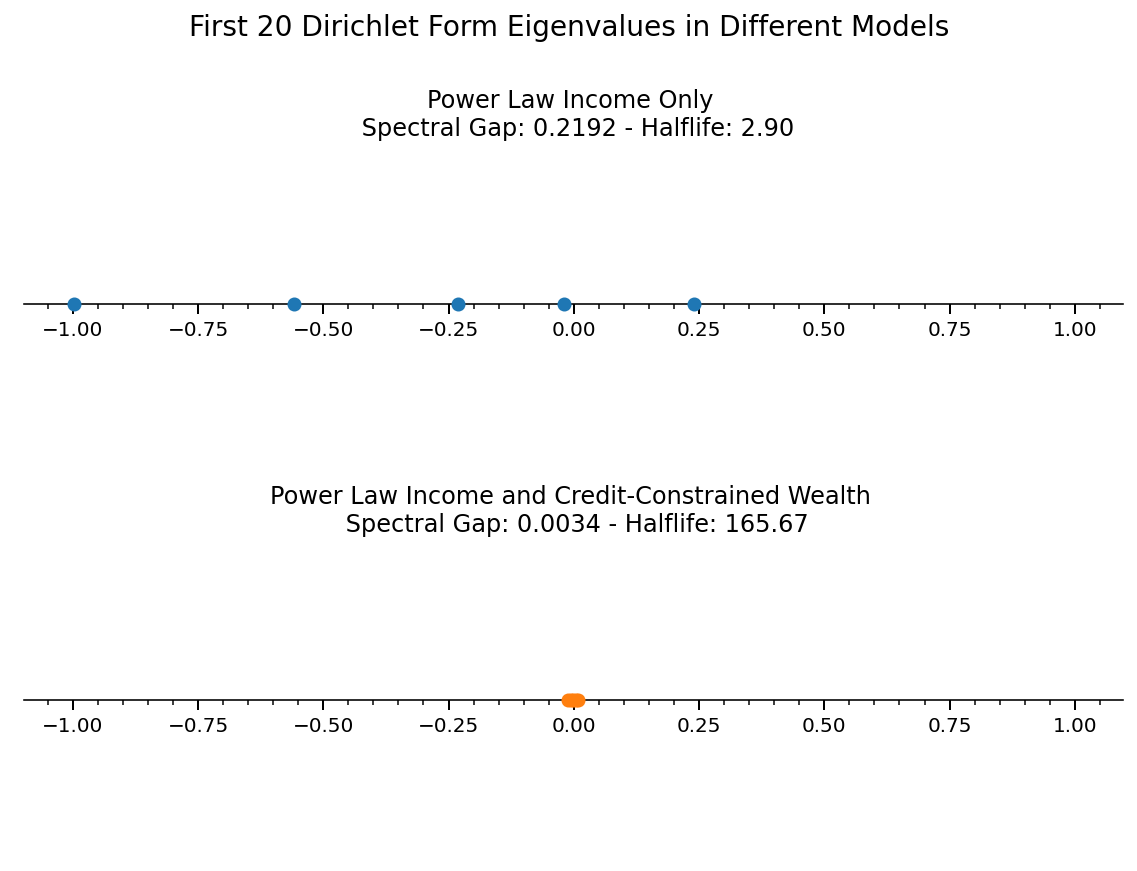

Saved to: eigenvalues_dirichlet_form_eigenvalues_shareaxes.pdf


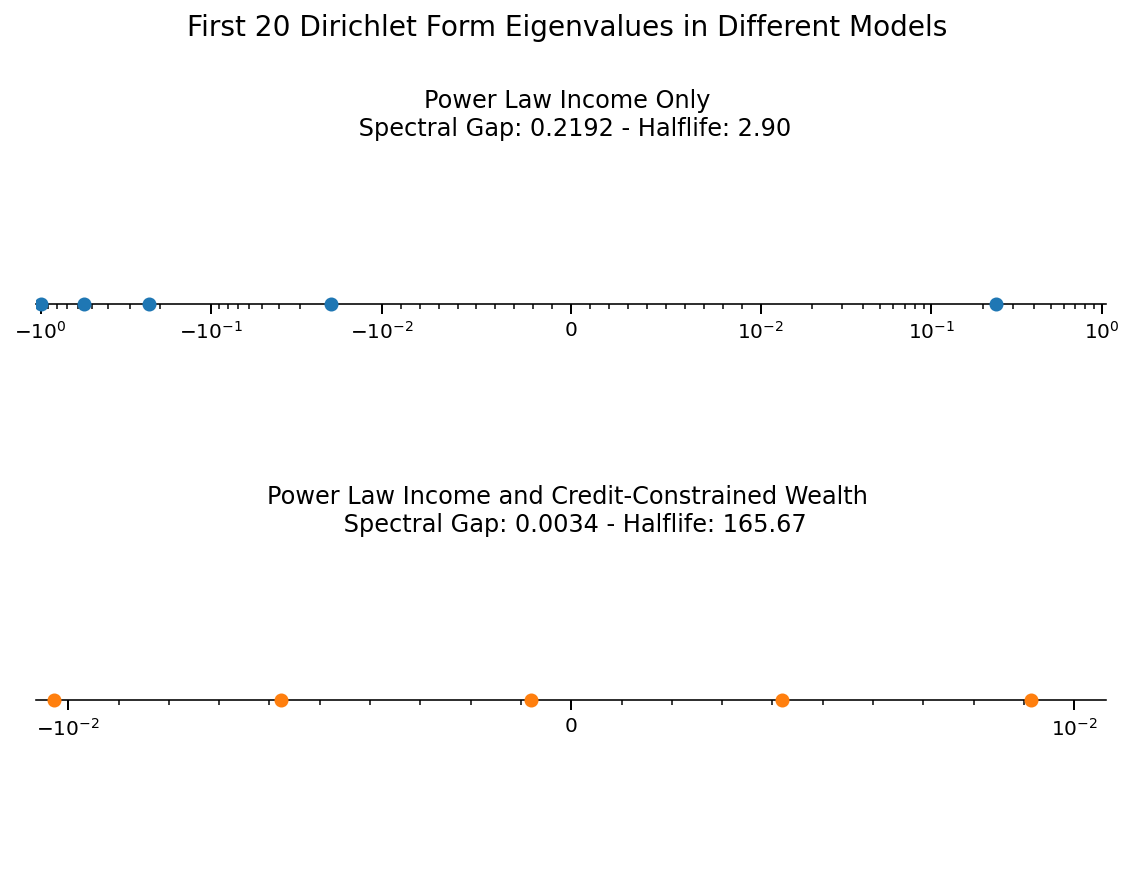

Saved to: eigenvalues_dirichlet_form_eigenvalues_logaxes.pdf


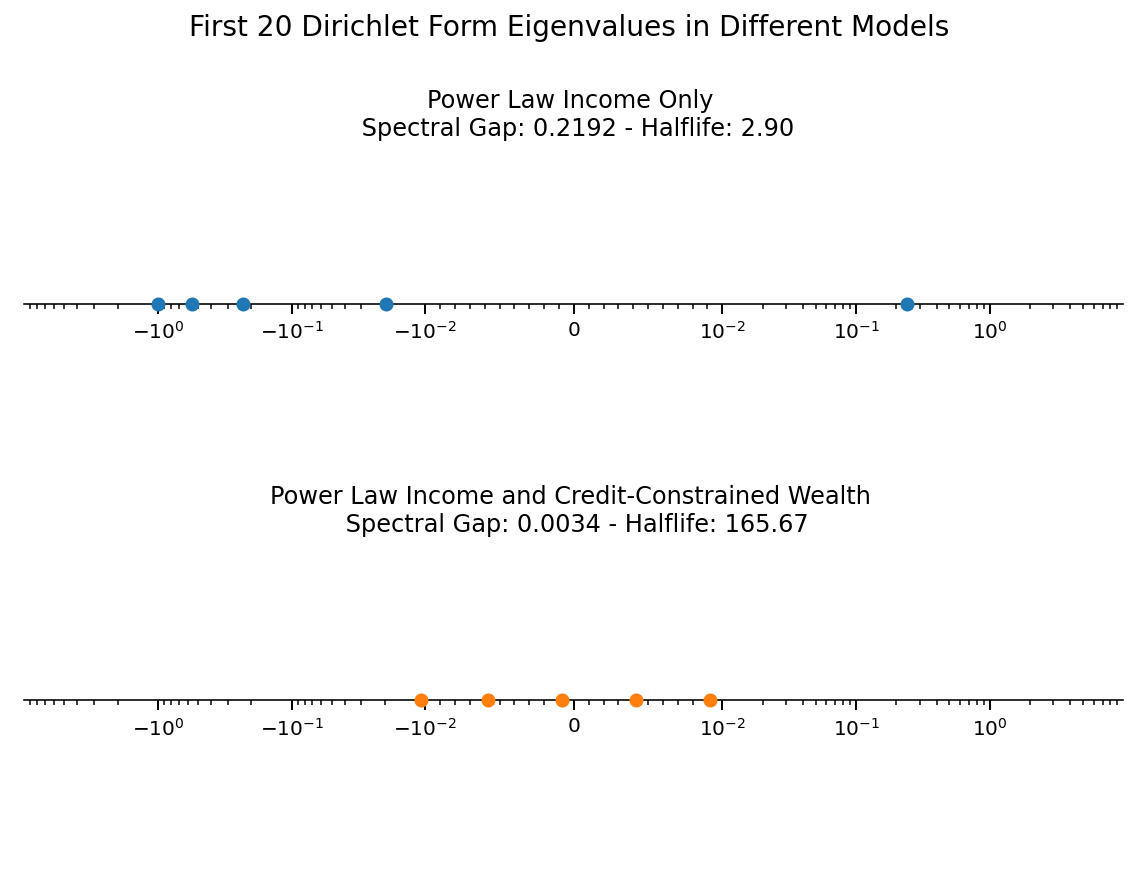

Saved to: eigenvalues_dirichlet_form_eigenvalues_shareaxes_logaxes.pdf


In [25]:
for logaxes in [False, True]:
    for shareaxes in [False, True]:
        
        absxmax = 0

        fig, ax = plt.subplots(2, 1, figsize=(8,6))
        ax = ax.flatten()

        for i, l in enumerate(ls):
            
            ax[i].scatter(l, np.zeros_like(l), c=colors[i], zorder=3)

            ax[i].spines['right'].set_color('none')
            ax[i].spines['left'].set_color('none')
            ax[i].yaxis.set_major_locator(ticker.NullLocator())
            ax[i].spines['top'].set_color('none')
            ax[i].xaxis.set_ticks_position('bottom')
            ax[i].spines['bottom'].set_position('zero')
            
            ax[i].tick_params(which='major', width=1.00)
            ax[i].tick_params(which='major', length=5)
            ax[i].tick_params(which='minor', width=0.75)
            ax[i].tick_params(which='minor', length=2.5)
            ax[i].patch.set_alpha(0.0)
            
            if shareaxes:
                if logaxes: absxmax = np.maximum(absxmax, 10*np.abs(np.real(l)).max())
                else: absxmax = np.maximum(absxmax, 1.1*np.abs(np.real(l)).max())
                ax[i].set_xlim([-absxmax, absxmax])
            else:
                ax[i].set_xlim([-np.abs(ax[i].get_xlim()).max(), np.abs(ax[i].get_xlim()).max()])
                
            ax[i].xaxis.set_major_locator(ticker.AutoLocator())
            if logaxes:
                ax[i].set_xscale('symlog', linthresh=1e-2)
                ax[i].xaxis.set_minor_locator(MinorSymLogLocator(linthresh=1e-2))
            else:
                ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
                

            gap = np.abs(l[1])-np.abs(l[0])
            halflife = np.log(2)/l[1]
            ax[i].set_title(titles[i]+f' \n Spectral Gap: {gap:.4f} - Halflife: {halflife:.2f}')

        plt.suptitle('First 20 Dirichlet Form Eigenvalues in Different Models', size=14, y=1)
        plt.tight_layout()
        filename = 'eigenvalues_dirichlet_form_eigenvalues'
        if shareaxes: filename += '_shareaxes'
        if logaxes: filename += '_logaxes'
        savefig(fig, filename)

In [39]:
(1/2)*(g**2)/s2

0.009166712789639202

In [46]:
print(L_income_only[1])
print(l_income_only)

(0.007262380957179309+0j)
[-0.01969537  0.23891697 -0.2306932  -0.55795751 -0.99687832]
